In [1]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump

In [2]:
df_train = pd.read_csv("../data/train_twitter.csv")
df_test = pd.read_csv("../data/test_twitter.csv")

print(f"Train shape: {df_train.shape}, Test shape: {df_test.shape}")

# ==== 2. Pilih fitur dan target ====

selected_features = ['friends_count', 'account_age_days', 'favourites_count', 'username_length',
                     'is_verified', 'description_length', 'has_custom_cover_image', 'username_digit_count',
                     'statuses_count', 'followers_count', 'followers_to_friends_ratio', 'has_location']
target_column = 'account_type'
df_train
df_test

Train shape: (29951, 13), Test shape: (7487, 13)


,has_custom_cover_image,description_length,favourites_count,followers_count,friends_count,followers_to_friends_ratio,has_location,username_digit_count,username_length,statuses_count,is_verified,account_age_days,account_type
0,0,36,88,753678,116,6441.692308,1.0,0,13,4202,1,3138,0
1,0,26,127,32,0,32.000000,1.0,0,13,921,0,3175,0
2,0,64,16614,262121,643,407.020186,1.0,0,15,36392,1,4220,0
3,0,78,12686,2365,296,7.962963,0.0,0,10,18309,0,3125,0
4,0,69,588,163616,115,1410.482759,1.0,0,11,77975,1,4507,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,0,60,1610,472,525,0.897338,0.0,0,11,23893,0,4143,0
7483,0,65,1265,1416800,358,3946.518106,1.0,1,11,2814,1,3299,0
7484,0,134,19377,498,378,1.313984,1.0,0,10,14233,0,4592,0
7485,0,7,1887,15,27,0.535714,1.0,0,8,3112,0,3652,0


In [3]:
# Pastikan semuanya float (atau int)
for feature in selected_features:
    for df in [df_train, df_test]:
        if np.issubdtype(df[feature].dtype, np.datetime64):
            df[feature] = pd.to_datetime(df[feature]).astype(np.int64) // 10**9
        else:
            df[feature] = df[feature].astype(float)

In [4]:
combined_df = pd.concat([df_train, df_test], ignore_index=True)

# 3. Pisahkan fitur dan account_type
X = combined_df.drop(columns=["account_type"])
y = combined_df["account_type"]

In [5]:
X = X.fillna(X.mean())

In [7]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "model__C": [0.01, 0.1, 1, 10]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [100, 125, 200],
            "model__max_depth": [None, 10, 20, 40]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 6]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7]
        }
    }
}

c:\Users\ACER\AppData\Local\Programs\Orange\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
best_models = []

# Training & tuning semua model
for name, config in models.items():
    print(f"🔍 Training {name}...")
    
    # Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', config["model"])
    ])
    
    # GridSearchCV
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=config["params"],
        scoring="roc_auc",
        cv=5,
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_score = grid.best_score_
    best_models.append((name, grid.best_estimator_, best_score))
    
    print(f"✅ {name} - Best AUC: {best_score:.4f}")
    print(f"   Best Params: {grid.best_params_}\n")

🔍 Training LogisticRegression...
✅ LogisticRegression - Best AUC: 0.7991
   Best Params: {'model__C': 10}

🔍 Training RandomForest...
✅ RandomForest - Best AUC: 0.9353
   Best Params: {'model__max_depth': 20, 'model__n_estimators': 200}

🔍 Training XGBoost...


c:\Users\ACER\AppData\Local\Programs\Orange\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\ACER\AppData\Local\Programs\Orange\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ XGBoost - Best AUC: 0.9349
   Best Params: {'model__max_depth': 6, 'model__n_estimators': 100}

🔍 Training KNN...
✅ KNN - Best AUC: 0.8071
   Best Params: {'model__n_neighbors': 7}



In [10]:
# 🔝 Pilih model terbaik berdasarkan AUC
from sklearn.metrics import roc_auc_score

best_models.sort(key=lambda x: x[2], reverse=True)
best_name, best_model, best_auc = best_models[0]

print(f"🏆 Best Model: {best_name} | AUC: {best_auc:.4f}")

# Evaluasi di test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC on Test Set: {roc_auc_score(y_test, y_proba):.4f}")

# Simpan model terbaik
model_filename = f"best_model_{best_name}.joblib"
dump(best_model, model_filename)
print(f"\n💾 Model disimpan sebagai: {model_filename}")

🏆 Best Model: RandomForest | AUC: 0.9353

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5003
           1       0.86      0.76      0.81      2485

    accuracy                           0.88      7488
   macro avg       0.87      0.85      0.86      7488
weighted avg       0.88      0.88      0.88      7488

AUC on Test Set: 0.9340

💾 Model disimpan sebagai: best_model_RandomForest.joblib


In [11]:
# Cari model dengan skor tertinggi

best_models.sort(key=lambda x: x[2], reverse=True)
best_model_name, best_model, best_auc = best_models[0]
print(f"\nModel terbaik: {best_model_name} dengan AUC: {best_auc:.4f}")

# Prediksi dan evaluasi di test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Test AUC Score:", roc_auc_score(y_test, y_proba))


Model terbaik: RandomForest dengan AUC: 0.9353

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      5003
           1       0.86      0.76      0.81      2485

    accuracy                           0.88      7488
   macro avg       0.87      0.85      0.86      7488
weighted avg       0.88      0.88      0.88      7488

Test AUC Score: 0.9340353132185075



🎯 Accuracy on Test Set: 0.8785


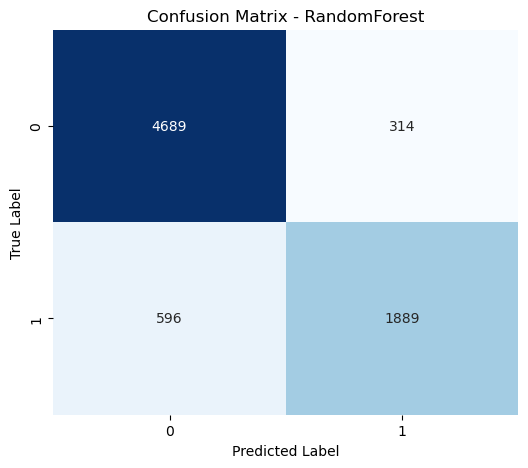

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy on Test Set: {acc:.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Save Model

In [13]:
dump(best_model, f"../models/best_model_Twitter{best_model_name}_v2.pkl")
print(f"Model terbaik berhasil disimpan sebagai best_model_Twitter{best_model_name}_v2.pkl")

Model terbaik berhasil disimpan sebagai best_model_TwitterRandomForest_v2.pkl
